In [1]:
import numpy as np

In [2]:
n_training_data = int(2e2)
n_bits = 8

In [5]:
x_train = np.random.randint(2, size = (n_training_data, n_bits))
x_train = np.array(x_train, dtype = np.float32)
y_train = np.array([np.sum(x) % 2 for x in x_train], dtype = np.float32)

# Float32: Pytorch gives preference for this type instead of Float64 (I believe Float32 is optimal for GPUs...)

In [8]:
print(x_train[0:2]) # first two entries
print(y_train[0:2])

[[1. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 1. 1. 0. 1. 0.]]
[0. 1.]


In [9]:
import torch
import torch.nn as nn # layer types
import torch.nn.functional as func # useful ML functions (activations) that are applied to layers

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() 
        # super gives access to attributes in a superclass from the subclass that inherits from it
        self.fc1= nn.Linear(n_bits, 100)
        self.fc2= nn.Linear(100, 1) 

    def forward(self, x):
        h = func.relu(self.fc1(x))
        y = torch.sigmoid(self.fc2(h)) # binary classification: sigmoid!
        return y
    
    def reset(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

In [11]:
model = Net().to(torch.device("cpu")) # inheritance!

In [12]:
import torch.optim as optim
learning_rate = 2e-1

In [13]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # not really going to do SGD...

In [14]:
inputs = torch.from_numpy(x_train)

In [15]:
targets = torch.from_numpy(y_train) # need an extra "superfluous" dimension
print(targets.size()) 
targets = torch.reshape(targets, (-1, 1))
print(targets.size()) 

torch.Size([200])
torch.Size([200, 1])


In [16]:
inputs.size()

torch.Size([200, 8])

In [17]:
model.forward(inputs).size()

torch.Size([200, 1])

In [18]:
loss = torch.nn.BCELoss(reduction='mean')
loss(model.forward(inputs), targets)

tensor(0.6913, grad_fn=<BinaryCrossEntropyBackward0>)

In [19]:
num_epochs = int(1e4)
display_epochs = int(1e3)

In [20]:
obj_vals= []

for epoch in range(num_epochs):   
    obj_val = loss(model.forward(inputs), targets)
    
    optimizer.zero_grad() # clear any previous gradients
    obj_val.backward() # backprop step, calculates gradient values
    optimizer.step() # apply gradients to model parameters
    
    obj_vals.append(obj_val.item())
    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\tLoss: {:.4f}'.format(epoch+1, num_epochs, obj_val.item()))

Epoch [1000/10000]	Loss: 0.1886
Epoch [2000/10000]	Loss: 0.0333
Epoch [3000/10000]	Loss: 0.0145
Epoch [4000/10000]	Loss: 0.0085
Epoch [5000/10000]	Loss: 0.0058
Epoch [6000/10000]	Loss: 0.0044
Epoch [7000/10000]	Loss: 0.0034
Epoch [8000/10000]	Loss: 0.0028
Epoch [9000/10000]	Loss: 0.0024
Epoch [10000/10000]	Loss: 0.0020


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

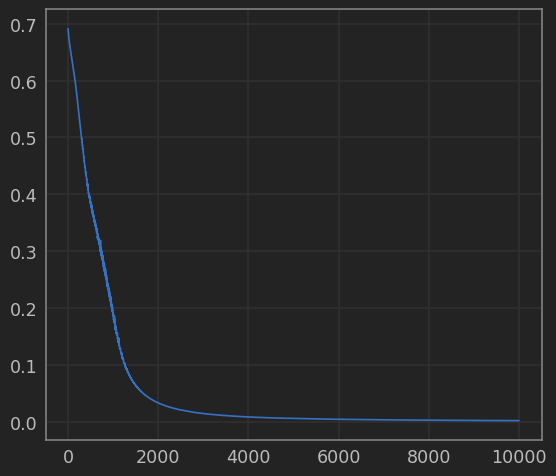

In [23]:
plt.plot(range(num_epochs), obj_vals)

In [24]:
n_test_data = int(1e2)
x_test = np.random.randint(2, size = (n_test_data, n_bits))
x_test = np.array(x_test, dtype = np.float32)
y_test = np.array([np.sum(x) % 2 for x in x_test], dtype = np.float32)

with torch.no_grad():
    inputs = torch.from_numpy(x_test)
    targets = torch.from_numpy(y_test)
    targets = torch.reshape(targets, (-1, 1))
    cross_val = loss(model.forward(inputs), targets)
    
print(cross_val)

tensor(0.1544)


In [27]:
obj_vals= []
cross_vals= []

model.reset() # reset your parameters

for epoch in range(num_epochs):
    inputs = torch.from_numpy(x_train)
    targets = torch.from_numpy(y_train)
    targets = torch.reshape(targets, (-1, 1))

    obj_val = loss(model.forward(inputs), targets)
    
    optimizer.zero_grad()
    obj_val.backward()
    optimizer.step()
    obj_vals.append(obj_val.item())

    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\t Training Loss: {:.4f}'.format(epoch+1, num_epochs, obj_val.item()))
            
    with torch.no_grad(): 
        # don't track calculations in the following scope for the purposes of gradients
        inputs = torch.from_numpy(x_test)
        targets = torch.from_numpy(y_test)
        targets = torch.reshape(targets, (-1, 1))
        cross_val = loss(model.forward(inputs), targets)
        cross_vals.append(cross_val)

    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\t Test Loss: {:.4f}'.format(epoch+1, num_epochs, cross_val.item()))
        
print('Final training loss: {:.4f}'.format(obj_vals[-1]))
print('Final test loss: {:.4f}'.format(cross_vals[-1]))

Epoch [1000/10000]	 Training Loss: 0.2309
Epoch [1000/10000]	 Test Loss: 0.4607
Epoch [2000/10000]	 Training Loss: 0.0404
Epoch [2000/10000]	 Test Loss: 0.2461
Epoch [3000/10000]	 Training Loss: 0.0176
Epoch [3000/10000]	 Test Loss: 0.2336
Epoch [4000/10000]	 Training Loss: 0.0105
Epoch [4000/10000]	 Test Loss: 0.2359
Epoch [5000/10000]	 Training Loss: 0.0072
Epoch [5000/10000]	 Test Loss: 0.2413
Epoch [6000/10000]	 Training Loss: 0.0054
Epoch [6000/10000]	 Test Loss: 0.2470
Epoch [7000/10000]	 Training Loss: 0.0042
Epoch [7000/10000]	 Test Loss: 0.2524
Epoch [8000/10000]	 Training Loss: 0.0035
Epoch [8000/10000]	 Test Loss: 0.2567
Epoch [9000/10000]	 Training Loss: 0.0029
Epoch [9000/10000]	 Test Loss: 0.2608
Epoch [10000/10000]	 Training Loss: 0.0025
Epoch [10000/10000]	 Test Loss: 0.2644
Final training loss: 0.0025
Final test loss: 0.2644


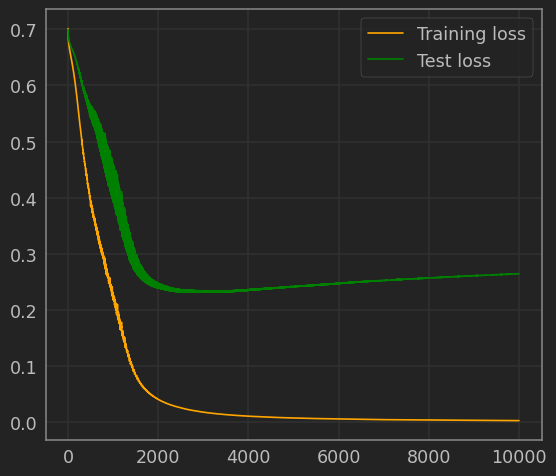

In [28]:
plt.plot(range(num_epochs), obj_vals, label= "Training loss", color="orange")
plt.plot(range(num_epochs), cross_vals, label= "Test loss", color= "green")
plt.legend()